In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from cpymad.madx import Madx
from matplotlib import cm, gridspec, patches

import xobjects as xo
import xline as xl
import xtrack as xt

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
with open('stdout.out', 'w') as f:
    madx = Madx(stdout=f)

In [3]:
# Read parameters

from config import parameters

for i in parameters.keys():
    madx.globals[i] = parameters[i]



In [4]:
# Call sequence and optics 

madx.call('elettra2_v15_VADER_2.3T.madx');

madx.input('''
select, flag=makethin, clear;
select, flag=makethin, class=sbend, slice=2;
select, flag=makethin, class=quadrupole, slice=2;
use, sequence=ring;
makethin, sequence=ring, style=teapot;
''');


madx.call('optics_elettra2_v15_VADER_2.3T.madx');

In [5]:
# Initial twiss

madx.use(sequence='ring')
madx.twiss(sequence='ring', table='init_twiss');
init_twiss = madx.table.init_twiss.dframe()
init_twiss.to_parquet('init_twiss.parquet')

In [6]:
line = xl.Line.from_madx_sequence(madx.sequence['ring'])

In [7]:
context = xo.ContextCpu()

In [29]:
tracker = xt.Tracker(_context=context, sequence=line)

generating ./f6a71a59b1cf408cad9d163a18a0f54b.c
the current directory is '/Users/apoyet/Work/2021/VADER/ELETTRA_LATTICE/MASK'
running build_ext
building 'f6a71a59b1cf408cad9d163a18a0f54b' extension
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/apoyet/anaconda3/envs/ELETTRA/include -arch x86_64 -I/Users/apoyet/anaconda3/envs/ELETTRA/include -arch x86_64 -I/Users/apoyet/anaconda3/envs/ELETTRA/include/python3.8 -c f6a71a59b1cf408cad9d163a18a0f54b.c -o ./f6a71a59b1cf408cad9d163a18a0f54b.o -std=c99 -O3 -Wno-unused-function
gcc -bundle -undefined dynamic_lookup -L/Users/apoyet/anaconda3/envs/ELETTRA/lib -arch x86_64 -L/Users/apoyet/anaconda3/envs/ELETTRA/lib -arch x86_64 -arch x86_64 ./f6a71a59b1cf408cad9d163a18a0f54b.o -o ./f6a71a59b1cf408cad9d163a18a0f54b.cpython-38-darwin.so -std=c99 -O3


In [30]:
n_part = 200
particles = xt.Particles(_context=context, p0c=2.4e9,x=np.random.uniform(-1e-3, 1e-3, n_part), zeta=np.random.uniform(-1e-2, 1e-2, n_part), delta=np.random.uniform(-1e-4, 1e-4, n_part))

In [31]:
tracker.track(particles, num_turns=1000, turn_by_turn_monitor=True)

In [32]:
x = tracker.record_last_track.x
y = tracker.record_last_track.y

px = tracker.record_last_track.px
py = tracker.record_last_track.py

In [33]:
np.shape(x[0,:])

(1000,)

(-0.001132232107555208,
 0.0012108466577858523,
 -0.00016310250652659292,
 0.00016065036119945888)

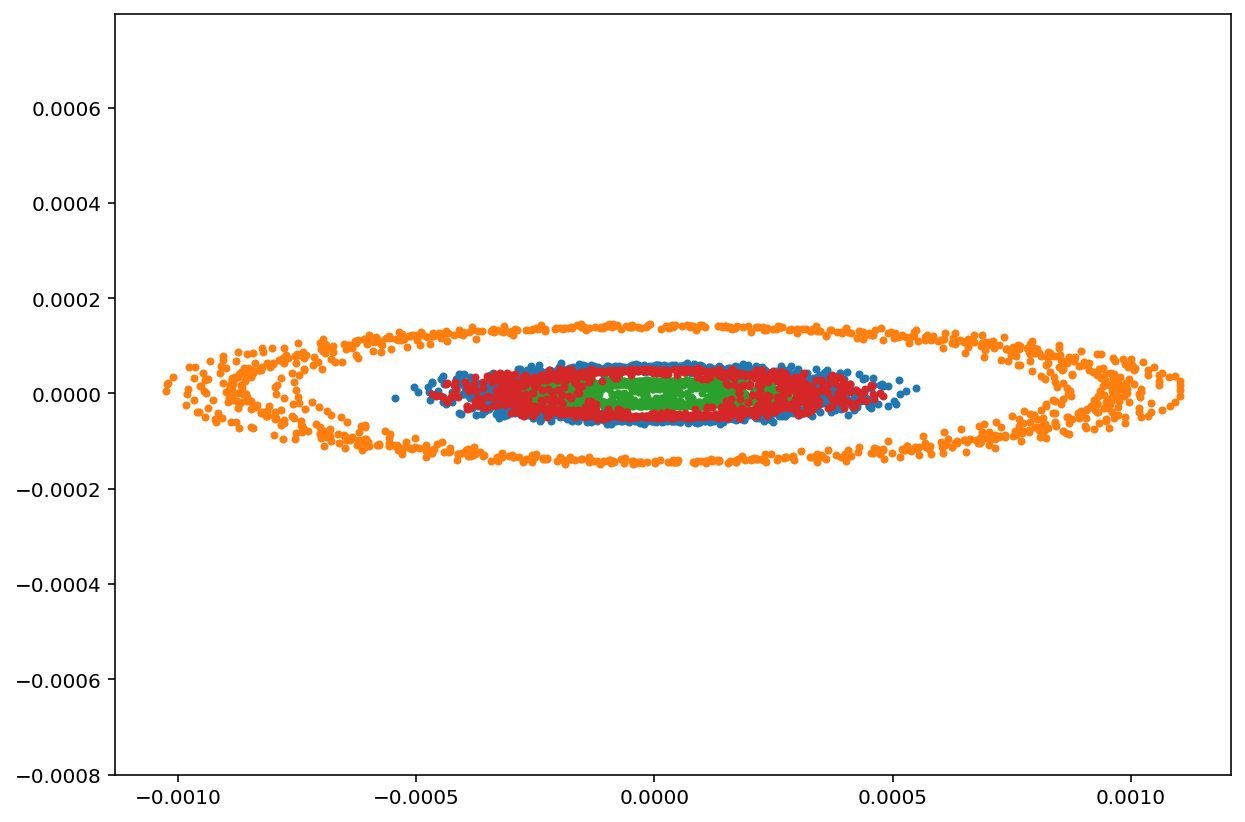

In [38]:
plt.figure(figsize=(10,7))

plt.plot(x[0,:], px[0,:],'.')

plt.plot(x[50,:], px[50,:],'.')

plt.plot(x[100,:], px[100,:],'.')

plt.plot(x[150,:], px[150,:],'.')

plt.axis('equal')

In [41]:
np.sqrt(np.mean(x[:,-1]**2)*np.mean(px[:,-1]**2) - np.mean(x[:,-1]*px[:,-1])**2)

2.527557449880559e-08

In [42]:
def setTotalEnergy_GeV(totalEnergy_GeV, restEnergy_GeV, elementaryCharge):
    """See signature."""
    speedOfLight_m_s = 299792458.0
    if restEnergy_GeV <= 0:
        print("Error: restEnergy_GeV should be greater than 0.")
        return
    if elementaryCharge == 0:
        print("Warning: elementaryCharge is set to zero, magneticRigidity_Tm is not undetermined.")
    if elementaryCharge < 0:
        print("Warning: elementaryCharge will be considered positive.")
        elementaryCharge = -elementaryCharge
    if totalEnergy_GeV >= restEnergy_GeV:
        relativisticGamma = totalEnergy_GeV / restEnergy_GeV
        totalEnergy_GeV = totalEnergy_GeV
        relativisticBeta = np.sqrt(1.0 - relativisticGamma ** -2)
        relativisticBetaGamma = relativisticGamma * relativisticBeta
        pc_GeV = restEnergy_GeV * np.sqrt(relativisticGamma ** 2 - 1)
        kinetikEnergy_GeV = totalEnergy_GeV - restEnergy_GeV
        if elementaryCharge == 0:
            magneticRigidity_Tm = np.nan
        else:
            magneticRigidity_Tm = 1.0e9 / speedOfLight_m_s * pc_GeV / elementaryCharge
        return {
            "totalEnergy_GeV": totalEnergy_GeV,
            "kinetikEnergy_GeV": kinetikEnergy_GeV,
            "pc_GeV": pc_GeV,
            "restEnergy_GeV": restEnergy_GeV,
            "relativisticBeta": relativisticBeta,
            "relativisticBetaGamma": relativisticBetaGamma,
            "relativisticGamma": relativisticGamma,
            "elementaryCharge": elementaryCharge,
            "magneticRigidity_Tm": magneticRigidity_Tm,
        }
    else:
        print("Error: totalEnergy should be equal or larger than restEnergy_GeV.")

In [43]:
beam_param_dict = setTotalEnergy_GeV(totalEnergy_GeV=2.4, restEnergy_GeV=0.510e-3, elementaryCharge=1)

In [44]:
beam_param_dict

{'totalEnergy_GeV': 2.4,
 'kinetikEnergy_GeV': 2.39949,
 'pc_GeV': 2.399999945812499,
 'restEnergy_GeV': 0.00051,
 'relativisticBeta': 0.9999999774218747,
 'relativisticBetaGamma': 4705.882246691174,
 'relativisticGamma': 4705.882352941176,
 'elementaryCharge': 1,
 'magneticRigidity_Tm': 8.005538104005602}